In [20]:
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [21]:
batch_size=16
epoch_count=50
noise_dm=100
n_class=10
tags=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
img_size=32
(X_train,y_train),(_,_)=cifar10.load_data()
X_train=(X_train-127.5)/127.5
X_train=X_train.astype('float32')
y_train=y_train.astype('int32')
dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train))
dataset=dataset.shuffle(buffer_size=1000).batch(batch_size,drop_remainder=True)


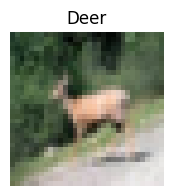

In [22]:
plt.figure(figsize=(2,2))
idx=np.random.randint(0,len(X_train))
img=image.array_to_img(X_train[idx],scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()

In [23]:
bce_loss=tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real,fake):
    real_loss=bce_loss(tf.ones_like(real),real)
    fake_loss=bce_loss(tf.zeros_like(fake),fake)
    total_loss=real_loss+fake_loss
    return total_loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds),preds)
d_optimizer=Adam(learning_rate=0.0002,beta_1=0.5)
g_optimizer=Adam(learning_rate=0.0002,beta_1=0.5)


In [24]:
## work of leaky relu if you know please ignore 
input_tensor=tf.constant([[-1,-2],[3,4]])
output_tensor=tf.nn.leaky_relu(input_tensor,alpha=0.1)
print(output_tensor)
## this is not part of cGAN 

tf.Tensor(
[[-0.1 -0.2]
 [ 3.   4. ]], shape=(2, 2), dtype=float32)


In [25]:
def build_generator():
    in_label = tf.keras.layers.Input(shape=(1,))
    li = tf.keras.layers.Embedding(n_class, 50)(in_label)

    n_nodes = 8 * 8
    li = tf.keras.layers.Dense(n_nodes)(li)
    li = tf.keras.layers.Reshape((8, 8, 1))(li)

    
    in_lat = tf.keras.layers.Input(shape=(noise_dm,))

    n_nodes = 128 * 8 * 8
    gen = tf.keras.layers.Dense(n_nodes)(in_lat)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((8, 8, 128))(gen)

    merge = tf.keras.layers.Concatenate()([gen, li])

    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(merge)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

    out_layer = tf.keras.layers.Conv2D(3, (8,8), activation='tanh', padding='same')(gen)

    model = tf.keras.models.Model([in_lat, in_label], out_layer)
    return model
g_model = build_generator()
g_model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8192)      │    827,392 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │        500 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 8192)      │          0 │ dense_5[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 64)     │      3,264 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 8, 8, 1)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8, 129) │          0 │ reshape_4[0][0],  │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 16, 16,    │    264,320 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 32, 32,    │    262,272 │ leaky_re_lu_6[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32, 3) │     24,579 │ leaky_re_lu_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,382,327 (5.27 MB)

 Trainable params: 1,382,327 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# build the discriminator 
def build_discriminator():
    in_label=tf.keras.layers.Input(shape=(1,))
    li=tf.keras.layers.Embedding(n_class,50)(in_label)
    n_nodes=img_size*img_size
    li=tf.keras.layers.Dense(n_nodes)(li)
    li=tf.keras.layers.Reshape((img_size,img_size,1))(li)
    in_image=tf.keras.layers.Input(shape=(img_size,img_size,3))
    merge=tf.keras.layers.Concatenate()([in_image,li])
    fe=tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(merge)
    fe=tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe=tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(fe)
    fe=tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe=tf.keras.layers.Flatten()(fe)
    fe=tf.keras.layers.Dropout(0.4)(fe)
    out_layers=tf.keras.layers.Dense(1,activation='sigmoid')(fe)
    model=Model([in_image,in_label],out_layers)
    return model
d_model=build_discriminator()
d_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 50)     │        500 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1, 1024)   │     52,224 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 32, 32, 1) │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32, 4) │          0 │ input_layer_7[0]… │
│ (Concatenate)       │                   │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │      4,736 │ concatenate_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 16, 16,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 8, 8, 128) │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192)      │          0 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8192)      │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │      8,193 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,237 (832.96 KB)

 Trainable params: 213,237 (832.96 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
@tf.function
def train_step(dataset):
    real_images,real_labels=dataset
    real_labels=tf.cast(real_labels, tf.int32)
    random_latent_vectors=tf.random.normal(shape=(batch_size,noise_dm))
    generated_images=g_model([random_latent_vectors,real_labels])
    with tf.GradientTape() as tape:
        pred_fake=d_model([generated_images,real_labels])
        pred_real=d_model([real_images,real_labels])
        d_loss=discriminator_loss(pred_real,pred_fake)
    grads=tape.gradient(d_loss,d_model.trainable_variables)
    d_optimizer.apply_gradients(zip(grads,d_model.trainable_variables))
    random_latent_vectors=tf.random.normal(shape=(batch_size,noise_dm))
    with tf.GradientTape() as tape:
        fake_images=g_model([random_latent_vectors,real_labels])
        predictions=d_model([fake_images,real_labels])
        g_loss=generator_loss(predictions)
    grads=tape.gradient(g_loss,g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads,g_model.trainable_variables))
    return d_loss,g_loss


In [28]:
def show_samples(num_samples,n_class,g_model):
    fig,axes=plt.subplots(10,num_samples,figsize=(10,20))
    fig.tight_layout()
    fig.subplots_adjust(wspace=None,hspace=0.2)
    for l in np.arange(10):
        random_noise=tf.random.normal(shape=(num_samples,noise_dm))
        labels=tf.fill((num_samples,1), tf.cast(l, tf.int32))
        gen_imgs=g_model.predict([random_noise,labels], verbose=0)
        for j in range(gen_imgs.shape[0]):
            img=image.array_to_img(gen_imgs[j],scale=True)
            axes[l,j].imshow(img)
            axes[l,j].yaxis.set_ticks([])
            axes[l,j].xaxis.set_ticks([])
            if j==0 :
                axes[l,j].set_ylabel(tags[l])
    plt.show()


Epoch 1/50


100%|██████████| 3125/3125 [17:04<00:00,  3.05it/s]


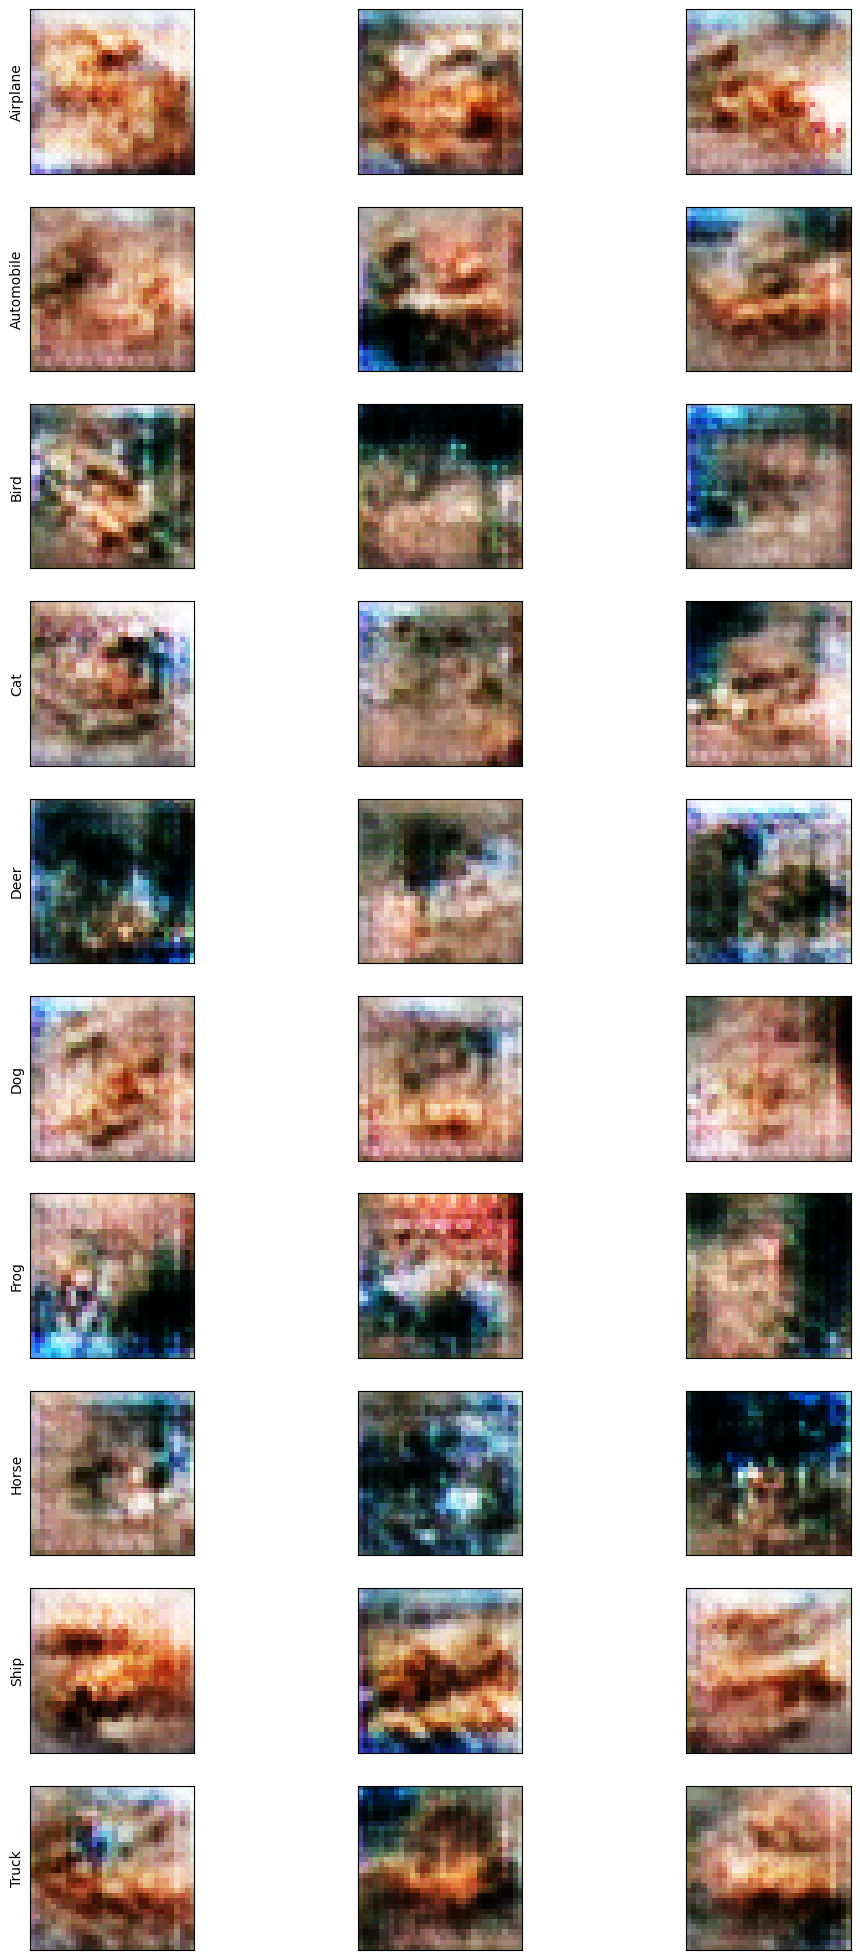

Generator Loss: 0.9182, Discriminator Loss: 1.2760
Took 1026.67 seconds.

Epoch 2/50


100%|██████████| 3125/3125 [14:12<00:00,  3.66it/s]


In [ ]:
def train(dataset, epochs=epoch_count):
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        d_loss_list = []
        g_loss_list = []
        start = time.time()
        for image_batch in tqdm(dataset):
            d_loss, g_loss = train_step(image_batch)
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)
        show_samples(3, n_class, g_model)
        mean_g=float(tf.reduce_mean(g_loss_list).numpy())
        mean_d=float(tf.reduce_mean(d_loss_list).numpy())
        print(f'Generator Loss: {mean_g:.4f}, Discriminator Loss: {mean_d:.4f}')
        print(f'Took {time.time()-start:.2f} seconds.\n')
train(dataset, epochs=epoch_count)
